# Simple scikitlearn for Allstate.
Just a simple linear regression with scikit. Well, that's how it started

ok, not so simple. I seem to keep adding junk.  currently using a several regressions, and plan to add in some nice gridsearch, etc.

In [36]:
import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression,Ridge

from sklearn import decomposition, datasets, ensemble
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
from IPython.display import display, Image

import xgboost as xgb


from subprocess import check_output
datadir="./input/"
print(check_output(["ls", datadir]).decode("utf8"))

%matplotlib inline  


test.csv.zip
train.csv.zip



## Some functions we use...

In [37]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        
def LabelEncoder(data):
    # lifted in parts from:
    #https://www.kaggle.com/mmueller/allstate-claims-severity/yet-another-xgb-starter/code
    features = data.columns
    cats = [feat for feat in features if 'cat' in feat]
    for feat in cats:
        data[feat] = pd.factorize(data[feat], sort=True)[0]
    return data

# XGB!

def xgbfit(X_train,y_train):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    

    xgb_params = {
        'seed': 0,
        'colsample_bytree': 0.7,
        'silent': 1,
        'subsample': 0.7,
        'learning_rate': 0.075,
        'objective': 'reg:linear',
        'max_depth': 6,
        'num_parallel_tree': 1,
        'min_child_weight': 1,
        'eval_metric': 'mae',
    }

    start_time = time.time()
    res = xgb.cv(xgb_params, dtrain, num_boost_round=750, nfold=4, seed=42, stratified=False,
                 early_stopping_rounds=15, verbose_eval=100, show_stdv=True, maximize=False)
    print("fit time:{}s".format(round((time.time()-start_time), 3) ))

    best_nrounds = res.shape[0] - 1
    cv_mean = res.iloc[-1, 0]
    cv_std = res.iloc[-1, 1]
    print('CV-Mean: {0}+{1}'.format(cv_mean, cv_std))
    # XGB Train!
    start_time = time.time()
    gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
    print("Train time:{}s".format(round((time.time()-start_time), 3) ))
    return gbdt

## Load the data!

In [107]:
data = loadData(datadir,'train.csv.zip')
display(data.info())
display(data.head(5))

test_data= loadData(datadir,'test.csv.zip') 
display(test_data.info())
display(test_data.head(5))

loading: ./input/train.csv.zip
Dataset has 188318 samples with 132 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


loading: ./input/test.csv.zip
Dataset has 125546 samples with 131 features each.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125546 entries, 0 to 125545
Columns: 131 entries, id to cont14
dtypes: float64(14), int64(1), object(116)
memory usage: 125.5+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,...,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,...,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,...,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


## Let's just take a moment with our data

In [39]:
#lets take a moment for the data
features = data.columns
cats = [feat for feat in features if 'cat' in feat]
conts = [feat for feat in features if 'cont' in feat]
print("total features:",len(features),"categories:",len(cats)," continuous:", len(conts))
print("average loss:",data['loss'].mean())
for feat in conts:
    print("Avg value for:",feat,data[feat].mean()) 
print(data[conts].mean())

('total features:', 132, 'categories:', 116, ' continuous:', 14)
('average loss:', 3037.3376856699833)
('Avg value for:', 'cont1', 0.49386136456419472)
('Avg value for:', 'cont2', 0.50718835617944102)
('Avg value for:', 'cont3', 0.49891845072165175)
('Avg value for:', 'cont4', 0.49181230258923736)
('Avg value for:', 'cont5', 0.48742772878322843)
('Avg value for:', 'cont6', 0.49094453373548996)
('Avg value for:', 'cont7', 0.48497020506802324)
('Avg value for:', 'cont8', 0.48643731586996469)
('Avg value for:', 'cont9', 0.48550631989507115)
('Avg value for:', 'cont10', 0.49806585042322038)
('Avg value for:', 'cont11', 0.49351100855467883)
('Avg value for:', 'cont12', 0.49315042562580319)
('Avg value for:', 'cont13', 0.4931376158359797)
('Avg value for:', 'cont14', 0.49571701797491485)
cont1     0.493861
cont2     0.507188
cont3     0.498918
cont4     0.491812
cont5     0.487428
cont6     0.490945
cont7     0.484970
cont8     0.486437
cont9     0.485506
cont10    0.498066
cont11    0.49351

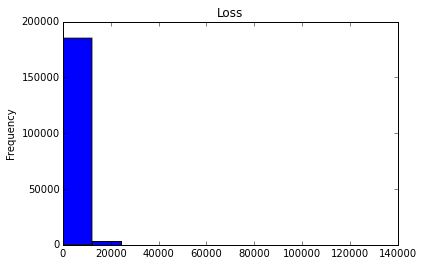

In [40]:
data['loss'].plot(kind='hist',title='Loss')

plt.show()

In [41]:
# hm....are all the values in the test_data seen in the train data?
for c in cats:
    values={}
    for v in data[c]:
        if v in values:
            values[v]+=1
        else:
            values[v]=1
    for v in test_data[c]:
        if v not in values:
            print(c,v,"not found in test!")
# hint...no they are not!

('cat89', 'F', 'not found in test!')
('cat89', 'F', 'not found in test!')
('cat92', 'G', 'not found in test!')
('cat92', 'E', 'not found in test!')
('cat92', 'E', 'not found in test!')
('cat96', 'H', 'not found in test!')
('cat99', 'U', 'not found in test!')
('cat103', 'M', 'not found in test!')
('cat106', 'Q', 'not found in test!')
('cat109', 'AD', 'not found in test!')
('cat109', 'AD', 'not found in test!')
('cat110', 'BH', 'not found in test!')
('cat110', 'CA', 'not found in test!')
('cat110', 'EN', 'not found in test!')
('cat111', 'L', 'not found in test!')
('cat113', 'AA', 'not found in test!')
('cat113', 'R', 'not found in test!')
('cat116', 'AQ', 'not found in test!')
('cat116', 'EM', 'not found in test!')
('cat116', 'FY', 'not found in test!')
('cat116', 'AI', 'not found in test!')
('cat116', 'N', 'not found in test!')
('cat116', 'ET', 'not found in test!')
('cat116', 'KO', 'not found in test!')
('cat116', 'BJ', 'not found in test!')
('cat116', 'IW', 'not found in test!')
('cat

## Pre Proccessing

In [108]:
# combine the two frames so we can encode the labels!
test_data['loss']=0

lengthofData=len(data)
lengthoftest_data=len(test_data)

combineddata=pd.concat([data,test_data])
lengthofcombined=len(combineddata)

# lets have a look at the results to make sure everything matched back up!
display(combineddata.info())
display(combineddata.head())

print("data:",lengthofData)
print("test:",lengthoftest_data)
print("combined:",lengthofcombined)
print("next two frames should match")
display(test_data.head())
display(combineddata.iloc[lengthofData:].head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313864 entries, 0 to 125545
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 318.5+ MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


('data:', 188318)
('test:', 125546)
('combined:', 313864)
next two frames should match


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,4,A,B,A,A,A,A,A,A,B,...,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,0
1,6,A,B,A,B,A,A,A,A,B,...,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,0
2,9,A,B,A,B,B,A,B,A,B,...,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,0
3,12,A,A,A,A,B,A,A,A,A,...,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,0
4,15,B,A,A,A,A,B,A,A,A,...,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,0


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,4,A,B,A,A,A,A,A,A,B,...,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,0.0
1,6,A,B,A,B,A,A,A,A,B,...,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,0.0
2,9,A,B,A,B,B,A,B,A,B,...,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,0.0
3,12,A,A,A,A,B,A,A,A,A,...,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,0.0
4,15,B,A,A,A,A,B,A,A,A,...,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,0.0


In [109]:
# the categorical data that we need in a number format
combineddata=LabelEncoder(combineddata)
display(combineddata.info())
display(combineddata.head())
display(combineddata.iloc[lengthofData:].head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313864 entries, 0 to 125545
Columns: 132 entries, id to loss
dtypes: float64(15), int64(117)
memory usage: 318.5 MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,0,1,0,1,0,0,0,0,1,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,0,1,0,0,0,0,0,0,1,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,0,1,0,0,1,0,0,0,1,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,1,1,0,1,0,0,0,0,1,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,0,1,0,1,0,0,0,0,1,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,4,0,1,0,0,0,0,0,0,1,...,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562,0.0
1,6,0,1,0,1,0,0,0,0,1,...,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045,0.0
2,9,0,1,0,1,1,0,1,0,1,...,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232,0.0
3,12,0,0,0,0,1,0,0,0,0,...,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955,0.0
4,15,1,0,0,0,0,1,0,0,0,...,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823,0.0


In [111]:
# time to split the data back apart!

data=combineddata.iloc[:lengthofData].copy()
test_data=combineddata.iloc[lengthofData:].copy()
test_data.drop(['loss'],1,inplace=True) # didn't have this column before, make it go away!

print("origdata:",lengthofData)
print("origtest:",lengthoftest_data)
lengthofData=len(data)
lengthoftest_data=len(test_data)
print("newdata:",lengthofData)
print("newtest:",lengthoftest_data)

('origdata:', 188318)
('origtest:', 125546)
('newdata:', 188318)
('newtest:', 125546)


In [112]:
# we don't want the ID columns in X, and of course not loss either
x=data.drop(['id','loss'],1).fillna(value=0)
# loss is our label
y=data['loss']

#minmax scaler
scaler= MinMaxScaler() 
x = scaler.fit_transform(x)

display(x.head(5))
display(y.head(5))
display(x.head(5))



,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


0    2213.18
1    1283.60
2    3005.09
3     939.85
4    2763.85
Name: loss, dtype: float64

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,...,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,...,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,...,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,...,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,...,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


## Time to actually starting fitting to a model!

In [47]:

#  train/validation split
X_train, X_test, y_train, y_test = train_test_split( x, 
                                                    y.values, 
                                                    test_size=0.25, 
                                                    random_state=42)

dataSize=X_train.shape[0]

# subdivide the data size, in case we'd like to train on some smaller portion, for speed 
print ("size of train data",dataSize, )
test_sizes=[50]
for i in range(5):
    test_sizes.append(int(round(dataSize*(i+1)*.2)))

print ("run tests of size",test_sizes)

('size of train data', 141238)
('run tests of size', [50, 28248, 56495, 84743, 112990, 141238])


In [48]:
# OK let's actually do some ML
regrList=[] # a list of regressions to use
#regrList.append(LinearRegression())
#regrList.append(SVR()) #long run time, high error!
regrList.append(ExtraTreesRegressor())
regrList.append(Ridge())
    
regrList.append(RandomForestRegressor(n_estimators=10,
                                      #criterion = 'mae',
                                      n_jobs =-1, 
                                      random_state=42))
#regrList.append(ensemble.AdaBoostRegressor())  ## The error rate is the bad!

#below xgb seems to be broken in some non-obvious way!
#regrList.append(xgb.XGBClassifier(max_depth=6, learning_rate=0.075, n_estimators=15,
#                                objective="reg:linear", subsample=0.7,
#                                colsample_bytree=0.7, seed=42))



#pca = decomposition.PCA(n_components = 100)
#regr = Pipeline(steps=[('pca', pca), ('classifier', regr )]) # set up the clf as a pipeline so we can do randomized PCA

#params=dict(fit_intercept=[True,False], normalize  = [True,False])
#grid_search = GridSearchCV(regr, param_grid= params, n_jobs= 1, scoring=make_scorer(f1_score)) 
#grid_search.fit(X_train,y_train)

for i in range(len(regrList)): # for each of the regressions we use, fit the data
    start_time = time.time()
    regrList[i].fit(X_train[ :test_sizes[3]],y_train[ :test_sizes[3]] )
    print("fit time:{}s".format(round((time.time()-start_time), 3) ))

fit time:37.719s
fit time:9.062s
fit time:15.212s


In [49]:
# ok, now lets predict with each regression, and spit out some score(MAE) data 
# so we know how it actually did! 
cache=[]
start_time0 = time.time()
for i in range(len(regrList)):
    start_time = time.time()
    print(regrList[i])
    cache.append(regrList[i].predict(X_test))
    print("Mean abs error: {:.2f}".format(np.mean(abs(cache[i] - y_test))))
    print("Score: {:.2f}".format(regrList[i].score(X_test, y_test)))
    print("predict time:{}s".format(round((time.time()-start_time), 3) ))
print("run time:{}s".format(round((time.time()-start_time0), 3) ))     

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
Mean abs error: 1319.08
Score: 0.48
predict time:1.053s
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Mean abs error: 1331.15
Score: 0.48
predict time:0.028s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
Mean abs error: 1321.61
Score: 0.48
predict time:0.43s
run time:1.511s


In [50]:
#XGB -- it doesn't fit the pattern of scikit, so do it seperatly
dtest = xgb.DMatrix(X_test)
gbdt=xgbfit(X_train,y_train)

[0]	train-mae:2811.02+3.97931	test-mae:2811.02+12.1945
[100]	train-mae:1161.54+0.634722	test-mae:1208.54+2.49224
[200]	train-mae:1119.87+1.17844	test-mae:1193.85+3.12648
[300]	train-mae:1092.19+1.12244	test-mae:1190.1+3.04959
fit time:302.07s
CV-Mean: 1189.44158925+2.9419384425
Train time:94.707s


In [51]:
# now do a prediction and spit out a score(MAE) that means something
start_time = time.time()
print("Mean abs error: {:.2f}".format(np.mean(abs(gbdt.predict(dtest) - y_test))))
print("predict time:{}s".format(round((time.time()-start_time), 3) ))

Mean abs error: 1180.77
predict time:0.493s


## Ok Things look good, use that to train on the whole data set

In [52]:
# refit the full train data!
for i in range(len(regrList)):
    start_time = time.time()
    print(regrList[i])
    regrList[i].fit(x ,y )
    print("re-fit time:{}s".format(round((time.time()-start_time), 3) ))

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
re-fit time:71.25s
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
re-fit time:4.314s
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
re-fit time:32.263s


In [53]:
# My xgb is a diff format, do it here instead
start_time = time.time()
regrList.append(xgbfit(x,y))
print("re-fit time:{}s".format(round((time.time()-start_time), 3) ))

[0]	train-mae:2809.84+7.17522	test-mae:2809.9+23.9038
[100]	train-mae:1166.62+2.09412	test-mae:1205.44+4.37469
[200]	train-mae:1129.72+1.90519	test-mae:1190.38+3.86575
[300]	train-mae:1106.45+1.63335	test-mae:1186.1+3.66609
fit time:441.123s
CV-Mean: 1184.63510125+3.70121793859
Train time:137.611s
re-fit time:579.335s


## predictions for our results..

In [113]:
# predict the test data!
start_time0 = time.time()

# don't need the id 
test_X=test_data.drop(['id'],1).fillna(value=0)

#minmax scaler
scaler= MinMaxScaler() 
test_X = scaler.fit_transform(test_X)
#make our predictions and then average them
# we'll do one for each prediction, store/add them up in the loss colum
test_data['loss']=0
for i in range(len(regrList)-1): 
    start_time = time.time()
    test_data['loss'+str(i)]= regrList[i].predict(test_X) 
    print("final predict time:{}s".format(round((time.time()-start_time), 3) ))
    
num_learners=i+1
#xgb needs the data in it's format...
dtest = xgb.DMatrix(test_X)
start_time = time.time()
test_data['loss'+str(num_learners)]=regrList[num_learners].predict(dtest) 
print("final predict time:{}s".format(round((time.time()-start_time), 3) ))  
num_learners+=1
print("number of learners:",num_learners)

for ii in range(num_learners):
    test_data['loss']+=test_data['loss'+str(ii)]
test_data['loss']=test_data['loss']/num_learners

display(test_data.info())
display(test_data.head())

print("run time:{}s".format(round((time.time()-start_time0), 3) ))

final predict time:2.392s
final predict time:0.093s
final predict time:0.787s
final predict time:1.399s
('number of learners:', 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125546 entries, 0 to 125545
Columns: 136 entries, id to loss3
dtypes: float32(1), float64(18), int64(117)
memory usage: 130.7 MB


None

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont10,cont11,cont12,cont13,cont14,loss,loss0,loss1,loss2,loss3
0,4,0,1,0,0,0,0,0,0,1,...,0.38016,0.377724,0.369858,0.704052,0.392562,1557.481163,1842.459,1163.444149,1414.256,1809.765503
1,6,0,1,0,1,0,0,0,0,1,...,0.60401,0.689039,0.675759,0.453468,0.208045,2319.176513,2306.525,1967.440057,2970.944,2031.796997
2,9,0,1,0,1,1,0,1,0,1,...,0.30529,0.245410,0.241676,0.258586,0.297232,9766.424801,9190.110,11395.080460,9324.873,9155.635742
3,12,0,0,0,0,1,0,0,0,0,...,0.31480,0.348867,0.341872,0.592264,0.555955,5678.733128,6042.771,5747.092697,4307.957,6617.111816
4,15,1,0,0,0,0,1,0,0,0,...,0.50556,0.359572,0.352251,0.301535,0.825823,695.982840,974.332,-24.410387,909.671,924.338745


run time:5.722s


In [114]:
# spit this out to be used for the submission!
#first, just the average loss column
print "writing Average loss"
result=test_data[['id','loss']] # we just need these for the submission
result.columns.values[1]='loss' # column should be named loss
display(result.info())
display(result.head())
output_fname="result_submission_"+'loss_avg'+".csv" 
writeData(result,output_fname)
# write a file out for each loss column, so we can submit any version we want!
for i in range(len(regrList)): 
    print "writing loss"+str(i)
    result=test_data[['id','loss'+str(i)]] # we just need these for the submission
    result.columns.values[1]='loss' # column should be named loss
    display(result.info())
    display(result.head())
    output_fname="result_submission_"+'loss'+str(i)+".csv" 
    writeData(result,output_fname)

writing Average loss
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125546 entries, 0 to 125545
Data columns (total 2 columns):
id      125546 non-null int64
loss    125546 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.9 MB


None

,id,loss
0,4,1557.481163
1,6,2319.176513
2,9,9766.424801
3,12,5678.733128
4,15,695.982840


writing loss0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125546 entries, 0 to 125545
Data columns (total 2 columns):
id      125546 non-null int64
loss    125546 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.9 MB


None

,id,loss
0,4,1842.459
1,6,2306.525
2,9,9190.110
3,12,6042.771
4,15,974.332


writing loss1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125546 entries, 0 to 125545
Data columns (total 2 columns):
id      125546 non-null int64
loss    125546 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.9 MB


None

,id,loss
0,4,1163.444149
1,6,1967.440057
2,9,11395.080460
3,12,5747.092697
4,15,-24.410387


writing loss2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125546 entries, 0 to 125545
Data columns (total 2 columns):
id      125546 non-null int64
loss    125546 non-null float64
dtypes: float64(1), int64(1)
memory usage: 2.9 MB


None

,id,loss
0,4,1414.256
1,6,2970.944
2,9,9324.873
3,12,4307.957
4,15,909.671


writing loss3
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125546 entries, 0 to 125545
Data columns (total 2 columns):
id      125546 non-null int64
loss    125546 non-null float32
dtypes: float32(1), int64(1)
memory usage: 2.4 MB


None

,id,loss
0,4,1809.765503
1,6,2031.796997
2,9,9155.635742
3,12,6617.111816
4,15,924.338745


### Stacking?

In [115]:
# I think that for stacking, I take my prediction for each method and retrain on that.
#cache=[np.array(len(X_train),1)] #make an empty array, to add each prediction set to
data_with_pred=data[['id','loss']].copy()
                    
display(data_with_pred.head(4))
start_time0 = time.time()

for i in range(len(regrList)-1): #don't use that last regression, it's xgb
    print(i,regrList[i])
    start_time = time.time()
    curr_predict = regrList[i].predict(x)
    data_with_pred['loss'+str(i)]=curr_predict
    #cache.append(regrList[i].predict(X_train), axis=1)

    print("Mean abs error: {:.2f}".format(np.mean(abs(curr_predict - y))))
    print("Score: {:.2f}".format(regrList[i].score(x, y)))
    print("predict time:{}s".format(round((time.time()-start_time), 3) ))
print("run time:{}s".format(round((time.time()-start_time0), 3) ))  

scaler= MinMaxScaler() 
x_with_pred=data_with_pred.drop(['id','loss'],1).fillna(value=0).copy()
x_with_pred = scaler.fit_transform(x_with_pred)
display(data_with_pred.head(3))
display(data_with_pred.info())
#del data_with_pred

#print(cache[1].shape)

,id,loss
0,1,2213.18
1,2,1283.60
2,5,3005.09
3,10,939.85


(0, ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False))
Mean abs error: 7142.96
Score: -8.05
predict time:3.81s
(1, Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))
Mean abs error: 7219.81
Score: -9.47
predict time:0.518s
(2, RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False))
Mean abs error: 9190.60
Score: -11.13
predict time:1.462s
run time:5.793s


,id,loss,loss0,loss1,loss2
0,1,2213.18,14554.691,-9733.647079,11243.488
1,2,1283.60,13987.862,8213.220906,11145.732
2,5,3005.09,4304.817,22194.923718,10264.200


<class 'pandas.core.frame.DataFrame'>
Int64Index: 188318 entries, 0 to 188317
Data columns (total 5 columns):
id       188318 non-null int64
loss     188318 non-null float64
loss0    188318 non-null float64
loss1    188318 non-null float64
loss2    188318 non-null float64
dtypes: float64(4), int64(1)
memory usage: 8.6 MB


None

In [116]:

# train XGB on data that included the predictions!
start_time = time.time()
gbdt=xgbfit(x_with_pred,y)
print("re-fit time:{}s".format(round((time.time()-start_time), 3) ))



[0]	train-mae:2810.01+7.27751	test-mae:2810.01+23.9462
fit time:6.742s
CV-Mean: 1493.82073975+10.5450741241
Train time:1.245s
re-fit time:8.045s


In [133]:
#ok, we trained xgb with the predictions, now make predictions based on that, and save them
test_data_with_pred=test_data[['id']].copy()
for ii in range(i+1):
    test_data_with_pred['loss'+str(ii)]=test_data['loss'+str(ii)]
print("number of learners in the stack:",len(regrList))
print(regrList)

test_data_with_pred.drop(['id'  ],1,inplace=True)
display(test_data_with_pred.head(5))


#minmax scaler
test_data_with_pred = scaler.fit_transform(test_data_with_pred)

dtest = xgb.DMatrix(test_data_with_pred)
#test_data.drop(['loss'] ,1,inplace=True)
test_data['loss']= gbdt.predict(dtest)

resultxgb=test_data[['id','loss',]]
output_fname="result_submission_stack.csv"
display(writeData(resultxgb,output_fname))



('number of learners in the stack:', 4)
[ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False), Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001), RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False), <xgboost.core.Booster object at 0x7fea81c94c10>]


,loss0,loss1,loss2
0,1842.459,1163.444149,1414.256
1,2306.525,1967.440057,2970.944
2,9190.110,11395.080460,9324.873
3,6042.771,5747.092697,4307.957
4,974.332,-24.410387,909.671


['id,loss\n',
 '4,1226.34313965\n',
 '6,1239.2208252\n',
 '9,4446.12353516\n',
 '12,1580.07043457\n']

#EOF